## Example of Information Theoretical Coclustering of Relational Data

In [1]:
import networkx as nx
import pandas
from utils.data_processing import *
from algorithms.information_theoretical_clustering import InformationTheoreticalClustering
from matplotlib import pyplot as plt
import matplotlib.cm as cm

Load the data and build a bipartite Graph where nodes are CellId and countries and edges are the number of calls between cells and countries.

In [2]:
cdr_data, antenna_mapping, most_called_countries = process_data('data/mobile-phone-activity/sms-call-internet-mi-2013-11-01.csv', truncate=2000)
itc = InformationTheoreticalClustering(cdr_data)

Function plotting two matrices:
1. the joint density in the blocks of a matrix (the darker the denser)
2. the mutual information matrix (red excess of interaction, blue lack of interation compared to expected in case of independence)

The joint density P(row,col) does not take into account that if clusters are unbalanced in terms of observations, the density will be high for the biggest cluster, though it might not show any interesting pattern. The mutual information corrects that problem by dividing the join probability by the marginal distribution over rows and columns:
\begin{align}
mi = P(row,col) log\left(\dfrac{P(row,col)}{P(row)P(col)}\right)
\end{align}

In [6]:
def plot_matrices(adjacency_matrix, mi_matrix, file_name=None):
    plt.clf()
    fig = plt.figure()
    ax1 = fig.add_subplot(121)
    ax1.imshow(adjacency_matrix, interpolation='nearest', cmap=cm.Greys, vmin=0, vmax=.25)
    ax2 = fig.add_subplot(122)
    ax2.imshow(mi_matrix, interpolation='nearest', cmap=cm.bwr, vmin=-0.15, vmax=0.15)
    plt.subplots_adjust(bottom=0.1, right=1.4, top=0.9)
    if file_name:
        plt.savefig(file_name, bbox_inches='tight')
    else:
        plt.show()

Generates random clusters and plot the clusters adjacency matrix to see that the density is randomly distributed over the blocks: 
- The adjacency matrix is normalized to obtain the joint probability matrix (left). No underlying structure seems to appear
- The mutual information is plotted on the right. All the cells arewhite meaning that the joint probability os somehow close to the product of the marginals (no pattern)

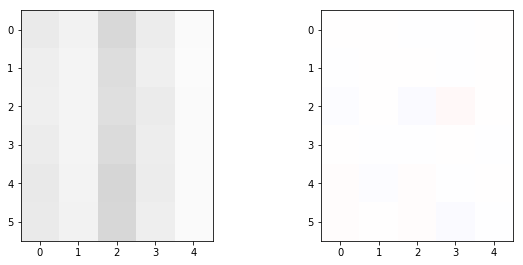

In [4]:
random_cell_clusters = InformationTheoreticalClustering.random_partition([node-1 for node in range(itc.adjacency_matrix.shape[0])], k=6)
random_country_clusters = InformationTheoreticalClustering.random_partition([node-1 for node in range(itc.adjacency_matrix.shape[1])], k=5)

random_adjacency_matrix = itc.build_cluster_join_probability_matrix(itc.adjacency_matrix, random_cell_clusters, dimension='cell')
random_adjacency_matrix = itc.build_cluster_join_probability_matrix(random_adjacency_matrix, random_country_clusters, dimension='country')

random_mi_matrix = InformationTheoreticalClustering.compute_mutual_information(random_adjacency_matrix)
random_probability_matrix = random_adjacency_matrix / float(random_adjacency_matrix.sum())
plot_matrices(random_probability_matrix, random_mi_matrix)

We apply the information theoretical clustering algorithm to the call detail records and plot the adjacency matrix of  the obtained clustering: 
- The adjacency matrix is normalized to obtain the joint probability matrix (left), reavealing a diagonal structure.
- The mutual information is plotted on the right. The matrix confirms the diagonal structure but emphasises certain interations that are not visible on the joint density matrix. For example row 4 and column 1, there is a pretty high density of interactions but way lower than expected if we consider the interactions emerging from clusters 1 and 4.

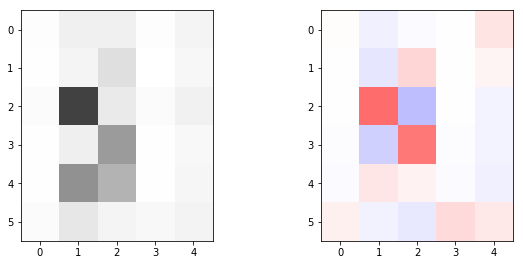

In [7]:
cell_clusters, country_clusters = itc.coclustering(k=6, l=5)

adjacency_matrix = itc.build_cluster_join_probability_matrix(itc.adjacency_matrix, cell_clusters, dimension='cell')
adjacency_matrix = itc.build_cluster_join_probability_matrix(adjacency_matrix, country_clusters, dimension='country')

probability_matrix = adjacency_matrix / float(adjacency_matrix.sum())
mi_matrix = InformationTheoreticalClustering.compute_mutual_information(adjacency_matrix)
 
plot_matrices(probability_matrix, mi_matrix, file_name=None)